<a href="https://colab.research.google.com/github/wkabbani/pytorch-playground/blob/main/huggingface-course/Unit01_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01. Unit 01.01

## 01.00 Setup

In [ ]:
!pip install -qq -U diffusers datasets transformers accelerate ftfy pyarrow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.9/524.9 KB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 66.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.5/191.5 KB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.0/36.0 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 76.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 15.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This be

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [ ]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import torchvision

def show_images(x):
  """Given a batch of images x, make a grid and convert to PIL"""
  x = x * 0.5 + 0.5 # map from (-1,1) to (0,1)
  grid = torchvision.utils.make_grid(x)
  grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0,1) * 255
  grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
  return grid_im

def make_grid(images, size=64):
  """Given a list of PIL images, stack them together into a line for easy viewing"""
  output_im = Image.new("RGB", (size * len(images), size))
  for i, im in enumerate(images):
      output_im.paste(im.resize((size, size)), (i * size, 0))
  return output_im

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 01.01. Data

In [ ]:
!ls '/path/to/dataset'

001_03_q30.jpg	024_03_q62.jpg	063_03_q60.jpg	102_03_q62.jpg	128_03_q45.jpg
002_03_q55.jpg	025_03_q43.jpg	064_03_q51.jpg	103_03_q60.jpg	129_03_q40.jpg
003_03_q43.jpg	026_03_q60.jpg	066_03_q51.jpg	104_03_q51.jpg	130_03_q58.jpg
004_03_q51.jpg	027_03_q64.jpg	067_03_q45.jpg	105_03_q60.jpg	131_03_q55.jpg
005_03_q55.jpg	029_03_q49.jpg	068_03_q60.jpg	107_03_q59.jpg	132_03_q58.jpg
006_03_q51.jpg	030_03_q54.jpg	069_03_q37.jpg	108_03_q46.jpg	134_03_q53.jpg
007_03_q45.jpg	031_03_q61.jpg	070_03_q54.jpg	112_03_q47.jpg	135_03_q51.jpg
008_03_q54.jpg	032_03_q61.jpg	081_03_q57.jpg	113_03_q51.jpg	136_03_q48.jpg
009_03_q60.jpg	033_03_q51.jpg	082_03_q65.jpg	114_03_q61.jpg	137_03_q67.jpg
010_03_q64.jpg	034_03_q60.jpg	083_03_q58.jpg	115_03_q47.jpg	138_03_q57.jpg
011_03_q61.jpg	036_03_q45.jpg	086_03_q51.jpg	117_03_q58.jpg	139_03_q53.jpg
012_03_q54.jpg	037_03_q59.jpg	087_03_q57.jpg	118_03_q62.jpg	140_03_q57.jpg
013_03_q33.jpg	038_03_q57.jpg	090_03_q60.jpg	119_03_q60.jpg	141_03_q56.jpg
014_03_q52.jpg	039_03_q42

In [ ]:
from datasets import load_dataset
from torchvision import transforms

dataset = load_dataset('/path/to/dataset', split='train')

Resolving data files:   0%|          | 0/102 [00:00<?, ?it/s]

In [ ]:
sample_image = dataset[0]
sample_image

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=413x531 at 0x7FF97BA23280>}

In [ ]:
batch_size = 16
image_size = 64
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]
)

def transform(examples):
  images = [preprocess(image.convert("RGB")) for image in examples['image']]
  return {"images": images}

dataset.set_transform(transform)

train_dl = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

X shape: torch.Size([4, 3, 64, 64])


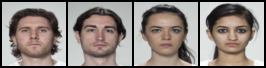

In [ ]:
xb = next(iter(train_dl))["images"].to(device)[:4]
print("X shape:", xb.shape)
show_images(xb)

## 01.02. Scheduler

In [ ]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

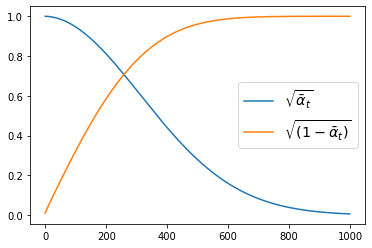

In [ ]:
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

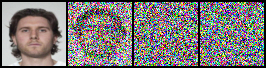

In [ ]:
timesteps = torch.linspace(0, 999, 4).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
show_images(noisy_xb)

## 01.03. Model

In [ ]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=image_size,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64, 128, 128, 256),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

model.to(device)

UNet2DModel(
  (conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0): ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
        (1): ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): Con

In [ ]:
with torch.inference_mode():
  prediction = model(noisy_xb, timesteps).sample
prediction.shape

torch.Size([4, 3, 64, 64])

## 01.04. Training

In [ ]:
from tqdm.auto import tqdm

# Set the noise scheduler
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)

# Training loop
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses = []

for epoch in tqdm(range(30)):
    for step, batch in enumerate(train_dl):
        clean_images = batch["images"].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        # Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()

    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dl) :]) / len(train_dl)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch:5, loss: 0.1284007951617241
Epoch:10, loss: 0.09026208892464638
Epoch:15, loss: 0.1016380318573543
Epoch:20, loss: 0.0835101269185543
Epoch:25, loss: 0.08657433092594147
Epoch:30, loss: 0.06807302417499679


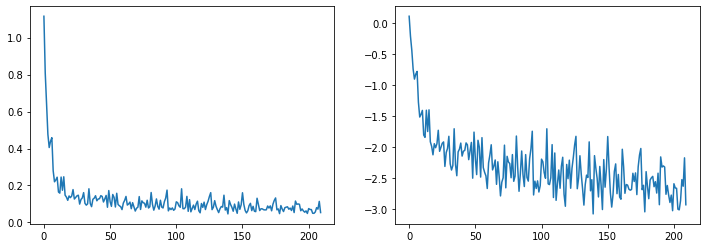

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

## 01.05. Generate Images

In [ ]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

  0%|          | 0/1000 [00:00<?, ?it/s]

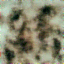

In [ ]:
pipeline_output = image_pipe()
pipeline_output.images[0]

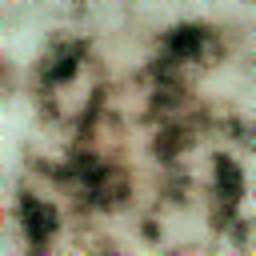

In [ ]:
pipeline_output.images[0].resize((1 * 256, 256))